In [7]:
# ===============================
# 0. Imports
# ===============================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_fscore_support
)

# ===============================
# 1. Load data
# ===============================
df = pd.read_csv("EN_combined_train_with_labels.csv.gz")
print(df.shape)
display(df.head())

# ===============================
# 2. Define target and features
# ===============================

# Target: psd_label_dcr (convert bool -> int)
y = df["psd_label_dcr"].astype(int)

# Columns we do NOT want as features
drop_cols = [
    "id",
    "energy_label",
    "psd_label_low_avse",
    "psd_label_high_avse",
    "psd_label_dcr",   # target
    "psd_label_lq",
]

# If you want a "baseline without Jade features", you can uncomment this:
# drop_cols += ["AvsE", "GradAreaRatio", "GradWidthMain", "HFER"]

feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols]

print("Feature columns:", feature_cols)
print("X shape:", X.shape, "   y shape:", y.shape)

print("\nClass balance for psd_label_dcr:")
print(y.value_counts())
print(y.value_counts(normalize=True))

# ===============================
# 3. Train–test split (stratified)
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nTrain size:", X_train.shape[0], " Test size:", X_test.shape[0])
print("Train class balance:")
print(y_train.value_counts(normalize=True))
print("Test class balance:")
print(y_test.value_counts(normalize=True))


# ===============================
# 4. Helper: evaluation function
# ===============================
def evaluate_classifier(name, model, X_test, y_test):
    """
    Prints metrics appropriate for imbalanced classification:
    - confusion matrix
    - precision, recall, f1 for each class
    - ROC AUC
    - PR AUC (Average Precision)
    """
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = None

    print("\n" + "="*70)
    print(f"Evaluation: {name}")
    print("="*70)

    print("Confusion matrix (rows = true, cols = predicted):")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=["neg (0)", "pos (1)"]))

    if y_score is not None:
        roc = roc_auc_score(y_test, y_score)
        ap  = average_precision_score(y_test, y_score)
        print(f"ROC AUC: {roc:.4f}")
        print(f"PR AUC (Average Precision): {ap:.4f}")
    else:
        print("No probability scores available for ROC/PR AUC.")


# ===============================
# 5. Baseline Logistic Regression
# ===============================
baseline_clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # handle NaNs
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight=None,    # pure baseline, no class balancing
        solver="lbfgs"
    )),
])

baseline_clf.fit(X_train, y_train)
evaluate_classifier("Baseline Logistic Regression (no class balancing)", baseline_clf, X_test, y_test)


# ===============================
# 6. Tuned Logistic Regression (class_weight='balanced')
# ===============================
logreg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight="balanced",   # upweight minority class
        solver="lbfgs"
    )),
])

param_grid_logreg = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

logreg_cv = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid_logreg,
    scoring="average_precision",   # PR AUC is good for imbalanced data
    cv=cv,
    n_jobs=-1,
    verbose=2
)

logreg_cv.fit(X_train, y_train)

print("\nBest params (LogReg):", logreg_cv.best_params_)
print("Best CV PR AUC (LogReg):", logreg_cv.best_score_)

best_logreg = logreg_cv.best_estimator_
evaluate_classifier("LogReg (class_weight balanced, tuned C)", best_logreg, X_test, y_test)


# ===============================
# 7. Random Forest (class_weight='balanced') with tuning
# ===============================
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # still need to handle NaNs
    ("rf", RandomForestClassifier(
        class_weight="balanced",
        n_estimators=200,
        n_jobs=-1,
        random_state=42
    )),
])

param_grid_rf = {
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10, 20],
    "rf__min_samples_split": [2, 10],
    "rf__min_samples_leaf": [1, 5],
}

rf_cv = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    scoring="average_precision",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    n_jobs=-1,
    verbose=2
)

rf_cv.fit(X_train, y_train)

print("\nBest params (RF):", rf_cv.best_params_)
print("Best CV PR AUC (RF):", rf_cv.best_score_)

best_rf = rf_cv.best_estimator_
evaluate_classifier("Random Forest (class_weight balanced, tuned)", best_rf, X_test, y_test)


# ===============================
# 8. (Optional) Summary table for report
# ===============================
results = []

def record_result(name, model, X_test, y_test):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = None

    y_pred = model.predict(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    roc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    ap  = average_precision_score(y_test, y_score) if y_score is not None else np.nan

    results.append({
        "model": name,
        "precision_pos": precision,
        "recall_pos": recall,
        "f1_pos": f1,
        "roc_auc": roc,
        "pr_auc": ap,
    })

record_result("Baseline Logistic", baseline_clf, X_test, y_test)
record_result("LogReg balanced + tuned", best_logreg, X_test, y_test)
record_result("RandomForest balanced + tuned", best_rf, X_test, y_test)

results_df = pd.DataFrame(results)
display(results_df)


(1040000, 29)


,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,late_over_early,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
0,0_train_0,582.364295,False,True,True,True,957,3409.0,2299.0,-717094.898532,...,0.987910,85.0,0.142357,3,1.198436,0.059642,0.519805,1.0,76.0,0.034772
1,1_train_0,250.159995,False,True,True,True,948,3404.0,2446.0,-331957.541919,...,0.988301,87.0,0.151160,3,1.381123,0.061975,0.531775,1.0,46.0,0.037621
2,2_train_0,1212.323954,False,True,False,True,965,3411.0,2262.0,-425532.152706,...,0.987491,95.0,0.142606,3,1.361857,0.050813,0.343676,1.0,90.0,0.035552
3,3_train_0,240.878110,False,True,True,False,927,3408.0,2833.0,-306980.459766,...,0.988450,116.0,0.133192,2,1.165654,0.062954,0.483144,1.0,56.0,0.035093
4,4_train_0,285.124189,False,True,True,False,958,3406.0,2397.0,-362746.925366,...,0.988541,94.0,0.145504,7,1.390918,0.055013,0.377738,1.0,53.0,0.035971


Feature columns: ['tp0', 'ED', 'HWP', 'LQ80', 'PPR', 'SC', 'current_skewness', 'spectral_centroid_power', 'tail_charge_diff', 'current_kurtosis', 'total_power', 'time_to_main_peak', 'time_to_peak', 'late_over_early', 'tdrift99', 'tfr', 'peak_count', 'gbn', 'bpr', 'AvsE', 'GradAreaRatio', 'GradWidthMain', 'HFER']
X shape: (1040000, 23)    y shape: (1040000,)

Class balance for psd_label_dcr:
psd_label_dcr
1    1019930
0      20070
Name: count, dtype: int64
psd_label_dcr
1    0.980702
0    0.019298
Name: proportion, dtype: float64

Train size: 832000  Test size: 208000
Train class balance:
psd_label_dcr
1    0.980702
0    0.019298
Name: proportion, dtype: float64
Test class balance:
psd_label_dcr
1    0.980702
0    0.019298
Name: proportion, dtype: float64

Evaluation: Baseline Logistic Regression (no class balancing)
Confusion matrix (rows = true, cols = predicted):
[[    85   3929]
 [    34 203952]]

Classification report:
              precision    recall  f1-score   support

     neg

/Users/jadechoi/miniforge3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best params (LogReg): {'logreg__C': 10.0}
Best CV PR AUC (LogReg): 0.9899394187097043

Evaluation: LogReg (class_weight balanced, tuned C)
Confusion matrix (rows = true, cols = predicted):
[[  2110   1904]
 [ 38534 165452]]

Classification report:
              precision    recall  f1-score   support

     neg (0)       0.05      0.53      0.09      4014
     pos (1)       0.99      0.81      0.89    203986

    accuracy                           0.81    208000
   macro avg       0.52      0.67      0.49    208000
weighted avg       0.97      0.81      0.88    208000

ROC AUC: 0.7175
PR AUC (Average Precision): 0.9896
Fitting 3 folds for each of 24 candidates, totalling 72 fits


/Users/jadechoi/miniforge3/lib/python3.10/site-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/Users/jadechoi/miniforge3/lib/python3.10/site-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/Users/jadechoi/miniforge3/lib/python3.10/site-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/Users/jadechoi/miniforge3/lib/python3.10/site-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/Users/jadechoi/miniforge3/lib/python3.10/site-packages/sklearn/utils/_array_api.py:839: RuntimeWarning: overflow encountered in cast
  array = numpy.asarray(array, order=order, dtype=dtype)
/Users/jadechoi/miniforge3/lib/python3.10/sit

KeyboardInterrupt: 

In [2]:
# ===============================
# 0. Imports
# ===============================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_fscore_support
)

import warnings
warnings.filterwarnings("ignore")


# ===============================
# 1. Load data
# ===============================
data_path = "EN_combined_train_with_labels.csv.gz"

df = pd.read_csv(data_path)
print("Data shape:", df.shape)
display(df.head())


# ===============================
# 1.1 Fix extreme LQ80 values (log-transform)
# ===============================
# LQ80 has absurd magnitudes (~1e124+), which break float32 inside RandomForest.
# We'll create a log-scaled version and drop the original.
df["LQ80_log"] = np.sign(df["LQ80"]) * np.log1p(np.abs(df["LQ80"]))

# Also clean any inf/-inf across all features, just in case:
df = df.replace([np.inf, -np.inf], np.nan)


# ===============================
# 2. Define target and features
# ===============================

# Target: psd_label_dcr (convert bool -> int)
y = df["psd_label_dcr"].astype(int)

# Columns we do NOT want as features
drop_cols = [
    "id",
    "energy_label",
    "psd_label_low_avse",
    "psd_label_high_avse",
    "psd_label_dcr",   # target
    "psd_label_lq",
    "LQ80",            # drop raw huge LQ80, use LQ80_log instead
]

feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols]

print("\nFeature columns:")
print(feature_cols)
print("X shape:", X.shape, "   y shape:", y.shape)

print("\nClass balance for psd_label_dcr (0 = majority minority flipped):")
print(y.value_counts())
print(y.value_counts(normalize=True))


# ===============================
# 3. Train–test split (stratified)
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("\nTrain size:", X_train.shape[0], " Test size:", X_test.shape[0])
print("Train class balance:")
print(y_train.value_counts(normalize=True))
print("Test class balance:")
print(y_test.value_counts(normalize=True))


# ===============================
# 4. Helper: evaluation + result recording
# ===============================
def evaluate_classifier(name, model, X_test, y_test):
    """
    Prints metrics appropriate for imbalanced classification:
    - confusion matrix
    - precision, recall, f1 for each class
    - ROC AUC
    - PR AUC (Average Precision)
    """
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = None

    print("\n" + "="*70)
    print(f"Evaluation: {name}")
    print("="*70)

    print("Confusion matrix (rows = true, cols = predicted):")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=["neg (0)", "pos (1)"]))

    if y_score is not None:
        roc = roc_auc_score(y_test, y_score)
        ap  = average_precision_score(y_test, y_score)
        print(f"ROC AUC: {roc:.4f}")
        print(f"PR AUC (Average Precision): {ap:.4f}")
    else:
        print("No probability scores available for ROC/PR AUC.")


results = []

def record_result(name, model, X_test, y_test):
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = None

    y_pred = model.predict(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )
    roc = roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    ap  = average_precision_score(y_test, y_score) if y_score is not None else np.nan

    results.append({
        "model": name,
        "precision_pos": precision,
        "recall_pos": recall,
        "f1_pos": f1,
        "roc_auc": roc,
        "pr_auc": ap,
    })


# ===============================
# 5. Baseline Logistic Regression
# ===============================
baseline_clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # handle NaNs
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight=None,    # pure baseline, no class balancing
        solver="lbfgs"
    )),
])

baseline_clf.fit(X_train, y_train)
evaluate_classifier("Baseline Logistic Regression (no class balancing)", baseline_clf, X_test, y_test)
record_result("Baseline Logistic", baseline_clf, X_test, y_test)


# ===============================
# 6. Tuned Logistic Regression (class_weight='balanced')
# ===============================
logreg_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(
        max_iter=1000,
        n_jobs=-1,
        class_weight="balanced",   # upweight minority class
        solver="lbfgs"
    )),
])

param_grid_logreg = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0]
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

logreg_cv = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid_logreg,
    scoring="average_precision",   # PR AUC is good for imbalanced data
    cv=cv,
    n_jobs=-1,
    verbose=2
)

logreg_cv.fit(X_train, y_train)

print("\nBest params (LogReg):", logreg_cv.best_params_)
print("Best CV PR AUC (LogReg):", logreg_cv.best_score_)

best_logreg = logreg_cv.best_estimator_
evaluate_classifier("LogReg (class_weight balanced, tuned C)", best_logreg, X_test, y_test)
record_result("LogReg balanced + tuned", best_logreg, X_test, y_test)


# ===============================
# 7. Random Forest (class_weight='balanced_subsample')
# ===============================
rf_clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),   # still need to handle NaNs
    ("rf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight="balanced_subsample",  # per-tree balancing
        n_jobs=-1,
        random_state=42
    )),
])

rf_clf.fit(X_train, y_train)

evaluate_classifier("Random Forest (balanced_subsample)", rf_clf, X_test, y_test)
record_result("Random Forest (balanced_subsample)", rf_clf, X_test, y_test)


# ===============================
# 8. Neural Network (MLP) model
# ===============================
# If this is too slow, you can subsample X_train for NN only:
# X_train_nn, _, y_train_nn, _ = train_test_split(
#     X_train, y_train,
#     train_size=200_000,      # or smaller if needed
#     stratify=y_train,
#     random_state=42
# )
# print("Using downsampled NN train size:", X_train_nn.shape[0])

# For now, use full training data:
X_train_nn, y_train_nn = X_train, y_train

nn_clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(64, 32),   # two hidden layers
        activation="relu",
        batch_size=1024,
        max_iter=20,                   # increase if it underfits and you have time
        alpha=1e-4,                    # L2 regularization
        learning_rate="adaptive",
        random_state=42,
        verbose=True                   # prints training progress
    )),
])

nn_clf.fit(X_train_nn, y_train_nn)

evaluate_classifier("Neural Network (MLP, 64-32)", nn_clf, X_test, y_test)
record_result("Neural Network (MLP, 64-32)", nn_clf, X_test, y_test)


# ===============================
# 9. Summary table for report
# ===============================
results_df = pd.DataFrame(results)
display(results_df.sort_values("pr_auc", ascending=False))


Data shape: (1040000, 29)


,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,late_over_early,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
0,0_train_0,582.364295,False,True,True,True,957,3409.0,2299.0,-717094.898532,...,0.987910,85.0,0.142357,3,1.198436,0.059642,0.519805,1.0,76.0,0.034772
1,1_train_0,250.159995,False,True,True,True,948,3404.0,2446.0,-331957.541919,...,0.988301,87.0,0.151160,3,1.381123,0.061975,0.531775,1.0,46.0,0.037621
2,2_train_0,1212.323954,False,True,False,True,965,3411.0,2262.0,-425532.152706,...,0.987491,95.0,0.142606,3,1.361857,0.050813,0.343676,1.0,90.0,0.035552
3,3_train_0,240.878110,False,True,True,False,927,3408.0,2833.0,-306980.459766,...,0.988450,116.0,0.133192,2,1.165654,0.062954,0.483144,1.0,56.0,0.035093
4,4_train_0,285.124189,False,True,True,False,958,3406.0,2397.0,-362746.925366,...,0.988541,94.0,0.145504,7,1.390918,0.055013,0.377738,1.0,53.0,0.035971



Feature columns:
['tp0', 'ED', 'HWP', 'PPR', 'SC', 'current_skewness', 'spectral_centroid_power', 'tail_charge_diff', 'current_kurtosis', 'total_power', 'time_to_main_peak', 'time_to_peak', 'late_over_early', 'tdrift99', 'tfr', 'peak_count', 'gbn', 'bpr', 'AvsE', 'GradAreaRatio', 'GradWidthMain', 'HFER', 'LQ80_log']
X shape: (1040000, 23)    y shape: (1040000,)

Class balance for psd_label_dcr (0 = majority minority flipped):
psd_label_dcr
1    1019930
0      20070
Name: count, dtype: int64
psd_label_dcr
1    0.980702
0    0.019298
Name: proportion, dtype: float64

Train size: 832000  Test size: 208000
Train class balance:
psd_label_dcr
1    0.980702
0    0.019298
Name: proportion, dtype: float64
Test class balance:
psd_label_dcr
1    0.980702
0    0.019298
Name: proportion, dtype: float64

Evaluation: Baseline Logistic Regression (no class balancing)
Confusion matrix (rows = true, cols = predicted):
[[    94   3920]
 [    45 203941]]

Classification report:
              precision   

,model,precision_pos,recall_pos,f1_pos,roc_auc,pr_auc
3,"Neural Network (MLP, 64-32)",0.985900,0.998848,0.992332,0.859493,0.995805
2,Random Forest (balanced_subsample),0.984624,0.999559,0.992035,0.857329,0.995207
1,LogReg balanced + tuned,0.988661,0.791216,0.878987,0.723170,0.990294
0,Baseline Logistic,0.981141,0.999779,0.990373,0.663427,0.987050


In [9]:
import numpy as np
import pandas as pd

# Load test (use Fix 1 path)
df_test = pd.read_csv("../nomin_csv_files/combined_test_n.csv.gz")

# Same preprocessing as train
if "LQ80" in df_test.columns:
    df_test["LQ80_log"] = np.sign(df_test["LQ80"]) * np.log1p(np.abs(df_test["LQ80"]))
df_test = df_test.replace([np.inf, -np.inf], np.nan)

# Align features
X_test_final = df_test.reindex(columns=feature_cols)

# Train NN on all labeled data (recommended for final)
nn_clf.fit(X, y)

# Predict + threshold
scores = nn_clf.predict_proba(X_test_final)[:, 1]
preds = (scores >= 0.5).astype(int)

# Save CSV in required format
submission = pd.DataFrame({
    "id": df_test["id"],
    "predicted_label_dcr": preds
})
submission.to_csv("psd_label_dcr_predictions_nn.csv", index=False)

submission.head()

Iteration 1, loss = 0.10030205
Iteration 2, loss = 0.07430229
Iteration 3, loss = 0.06998237
Iteration 4, loss = 0.06826132
Iteration 5, loss = 0.06729748
Iteration 6, loss = 0.06649361
Iteration 7, loss = 0.06586449
Iteration 8, loss = 0.06537221
Iteration 9, loss = 0.06485094
Iteration 10, loss = 0.06452727
Iteration 11, loss = 0.06418200
Iteration 12, loss = 0.06389244
Iteration 13, loss = 0.06344597
Iteration 14, loss = 0.06319253
Iteration 15, loss = 0.06296396
Iteration 16, loss = 0.06281954
Iteration 17, loss = 0.06250698
Iteration 18, loss = 0.06241342
Iteration 19, loss = 0.06223879
Iteration 20, loss = 0.06203568


,id,predicted_label_dcr
0,2395098_test_0,1
1,2395099_test_0,1
2,2395100_test_0,1
3,2395101_test_0,1
4,2395102_test_0,1


In [10]:
n1 = int((submission["predicted_label_dcr"] == 1).sum())
n0 = int((submission["predicted_label_dcr"] == 0).sum())
print("1s:", n1, "  0s:", n0, "  total:", n0+n1)

1s: 389893   0s: 107   total: 390000


In [11]:
scores = nn_clf.predict_proba(X_test_final)[:, 1]
print("min:", scores.min(), "max:", scores.max())
print("mean:", scores.mean(), "median:", np.median(scores))
print("pct below 0.5:", (scores < 0.5).mean())

min: 0.0004119160206226374 max: 0.9999999980431673
mean: 0.9981729534564867 median: 0.9990921979826661
pct below 0.5: 0.00027435897435897435


In [12]:
nn_clf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        batch_size=2048,
        max_iter=200,
        alpha=1e-4,
        learning_rate="adaptive",
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=10,
        random_state=42,
        verbose=True
    )),
])
nn_clf.fit(X_train, y_train)

Iteration 1, loss = 0.10023485
Validation score: 0.982380
Iteration 2, loss = 0.07678167
Validation score: 0.983293
Iteration 3, loss = 0.07197098
Validation score: 0.983726
Iteration 4, loss = 0.06942660
Validation score: 0.984159
Iteration 5, loss = 0.06811093
Validation score: 0.984243
Iteration 6, loss = 0.06716365
Validation score: 0.984507
Iteration 7, loss = 0.06655437
Validation score: 0.984387
Iteration 8, loss = 0.06602060
Validation score: 0.984748
Iteration 9, loss = 0.06554603
Validation score: 0.984784
Iteration 10, loss = 0.06518980
Validation score: 0.984700
Iteration 11, loss = 0.06485440
Validation score: 0.984796
Iteration 12, loss = 0.06442171
Validation score: 0.984784
Iteration 13, loss = 0.06423016
Validation score: 0.984760
Iteration 14, loss = 0.06391915
Validation score: 0.984748
Iteration 15, loss = 0.06366059
Validation score: 0.984796
Iteration 16, loss = 0.06347001
Validation score: 0.984844
Iteration 17, loss = 0.06312961
Validation score: 0.984868
Iterat

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('mlp',
                 MLPClassifier(batch_size=2048, early_stopping=True,
                               hidden_layer_sizes=(128, 64),
                               learning_rate='adaptive', random_state=42,
                               verbose=True))])

In [13]:
from sklearn.metrics import f1_score

val_scores = nn_clf.predict_proba(X_test)[:, 1]
thresholds = np.linspace(0.01, 0.99, 99)

best_t, best_f1 = 0.5, -1
for t in thresholds:
    pred = (val_scores >= t).astype(int)
    f1 = f1_score(y_test, pred, zero_division=0)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print("best threshold:", best_t, "best F1:", best_f1)

best threshold: 0.49 best F1: 0.9923406825438188


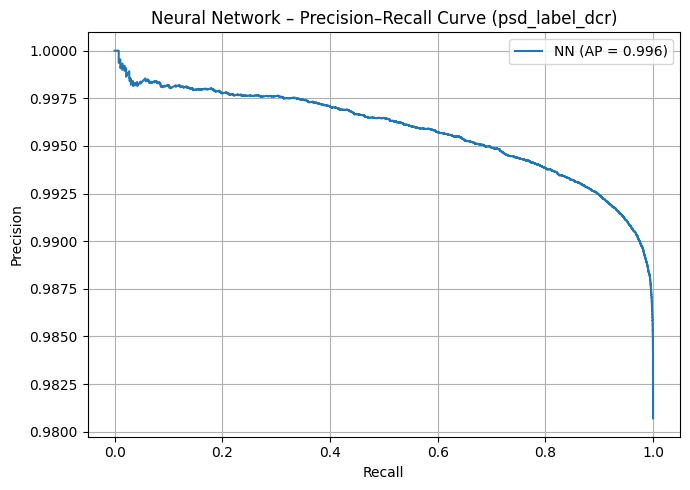

[CV] END ......................................logreg__C=0.1; total time=   4.6s
[CV] END ......................................logreg__C=1.0; total time=   4.7s
[CV] END ......................................logreg__C=0.1; total time=   5.1s
[CV] END .....................................logreg__C=0.01; total time=   4.6s
[CV] END .....................................logreg__C=10.0; total time=   3.3s
[CV] END ......................................logreg__C=1.0; total time=   4.5s
[CV] END .....................................logreg__C=10.0; total time=   3.4s
[CV] END ......................................logreg__C=1.0; total time=   3.4s
[CV] END .....................................logreg__C=0.01; total time=   4.8s
[CV] END .....................................logreg__C=10.0; total time=   3.4s
[CV] END ......................................logreg__C=0.1; total time=   4.5s


In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# NN scores
y_score_nn = nn_clf.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_score_nn)
ap_nn = average_precision_score(y_test, y_score_nn)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f"NN (AP = {ap_nn:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Neural Network – Precision–Recall Curve (psd_label_dcr)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

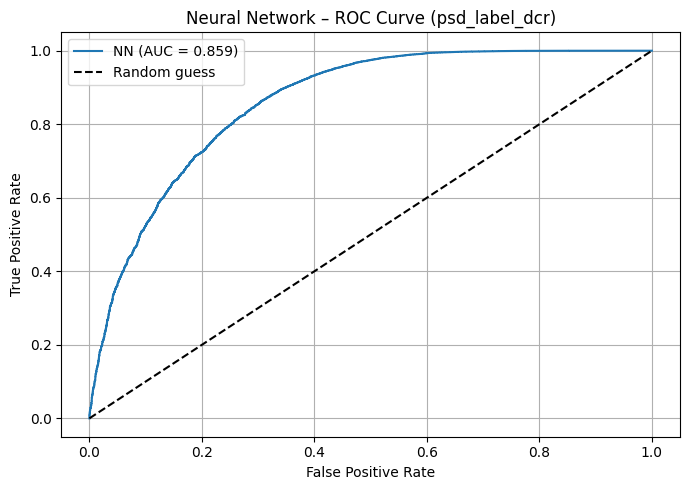

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr_nn, tpr_nn, _ = roc_curve(y_test, y_score_nn)
roc_auc_nn = roc_auc_score(y_test, y_score_nn)

plt.figure(figsize=(7, 5))
plt.plot(fpr_nn, tpr_nn, label=f"NN (AUC = {roc_auc_nn:.3f})")
plt.plot([0, 1], [0, 1], "k--", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Neural Network – ROC Curve (psd_label_dcr)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

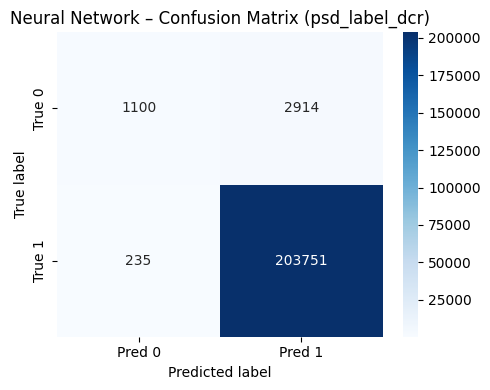

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_nn = nn_clf.predict(X_test)
cm_nn = confusion_matrix(y_test, y_pred_nn)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_nn,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Pred 0", "Pred 1"],
    yticklabels=["True 0", "True 1"]
)
plt.title("Neural Network – Confusion Matrix (psd_label_dcr)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

In [2]:
# ===============================
# 0. Imports
# ===============================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ===============================
# 1. Load data
# ===============================
df = pd.read_csv("EN_combined_train_with_labels.csv.gz")
print("Data shape:", df.shape)
display(df.head())

# ===============================
# 2. Fix LQ80 and infinities
# ===============================

# 2a. Create a log-transformed LQ80 (same idea as for classification)
#     log10(1 + |LQ80|) so it stays finite and not crazy huge
df["LQ80_log"] = np.where(
    df["LQ80"].abs() > 0,
    np.log10(df["LQ80"].abs() + 1.0),
    0.0
)

# 2b. Define target and drop columns we don't want as features
y = df["energy_label"].astype(float)

drop_cols = [
    "id",
    "energy_label",           # target
    "psd_label_low_avse",
    "psd_label_high_avse",
    "psd_label_dcr",
    "psd_label_lq",
    "LQ80",                   # drop raw LQ80, use LQ80_log instead
]

feature_cols = [c for c in df.columns if c not in drop_cols]
print("\nFeature columns:")
print(feature_cols)

# 2c. Build X and replace ±inf with NaN (so imputer can handle them)
X = df[feature_cols].replace([np.inf, -np.inf], np.nan)

print("X shape:", X.shape, "   y shape:", y.shape)

# ===============================
# 3. Train–test split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("\nTrain size:", X_train.shape[0], " Test size:", X_test.shape[0])

# ===============================
# 4. Helper: evaluation function
# ===============================
def evaluate_regressor(name, model, X_test, y_test):
    """
    Prints standard regression metrics:
      - MAE   (mean absolute error)
      - RMSE  (root mean squared error)
      - R^2   (coefficient of determination)
    """
    y_pred = model.predict(X_test)

    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    print("\n" + "="*70)
    print(f"Evaluation: {name}")
    print("="*70)
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"R^2  : {r2:.4f}")

    return {"model": name, "mae": mae, "rmse": rmse, "r2": r2}


results = []

# ===============================
# 5. Baseline: Linear Regression
# ===============================
baseline_linreg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

baseline_linreg.fit(X_train, y_train)
res_lin = evaluate_regressor("Baseline Linear Regression", baseline_linreg, X_test, y_test)
results.append(res_lin)

# ===============================
# 6. More complex model: Random Forest Regressor
# ===============================
rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    )),
])

rf.fit(X_train, y_train)
res_rf = evaluate_regressor("Random Forest (baseline)", rf, X_test, y_test)
results.append(res_rf)

# ===============================
# 7. Summary table
# ===============================
results_df = pd.DataFrame(results).sort_values("rmse")
display(results_df)


Data shape: (1040000, 29)


,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,late_over_early,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
0,0_train_0,582.364295,False,True,True,True,957,3409.0,2299.0,-717094.898532,...,0.987910,85.0,0.142357,3,1.198436,0.059642,0.519805,1.0,76.0,0.034772
1,1_train_0,250.159995,False,True,True,True,948,3404.0,2446.0,-331957.541919,...,0.988301,87.0,0.151160,3,1.381123,0.061975,0.531775,1.0,46.0,0.037621
2,2_train_0,1212.323954,False,True,False,True,965,3411.0,2262.0,-425532.152706,...,0.987491,95.0,0.142606,3,1.361857,0.050813,0.343676,1.0,90.0,0.035552
3,3_train_0,240.878110,False,True,True,False,927,3408.0,2833.0,-306980.459766,...,0.988450,116.0,0.133192,2,1.165654,0.062954,0.483144,1.0,56.0,0.035093
4,4_train_0,285.124189,False,True,True,False,958,3406.0,2397.0,-362746.925366,...,0.988541,94.0,0.145504,7,1.390918,0.055013,0.377738,1.0,53.0,0.035971



Feature columns:
['tp0', 'ED', 'HWP', 'PPR', 'SC', 'current_skewness', 'spectral_centroid_power', 'tail_charge_diff', 'current_kurtosis', 'total_power', 'time_to_main_peak', 'time_to_peak', 'late_over_early', 'tdrift99', 'tfr', 'peak_count', 'gbn', 'bpr', 'AvsE', 'GradAreaRatio', 'GradWidthMain', 'HFER', 'LQ80_log']
X shape: (1040000, 23)    y shape: (1040000,)

Train size: 832000  Test size: 208000

Evaluation: Baseline Linear Regression
MAE  : 64.838
RMSE : 103.914
R^2  : 0.9759

Evaluation: Random Forest (baseline)
MAE  : 7.435
RMSE : 45.440
R^2  : 0.9954


,model,mae,rmse,r2
1,Random Forest (baseline),7.435037,45.440350,0.995392
0,Baseline Linear Regression,64.838011,103.913987,0.975904


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ===============================
# 1. Load data
# ===============================
df = pd.read_csv("EN_combined_train_with_labels.csv.gz")
print("Data shape:", df.shape)
display(df.head())

# ===============================
# 2. Build feature matrix X and target y
# ===============================

# Target: energy_label for regression
y = df["energy_label"].astype(float)

# Create a log-transformed LQ80 to tame huge magnitudes (like you did before)
df["LQ80_log"] = np.sign(df["LQ80"]) * np.log1p(np.abs(df["LQ80"]))

# Columns we do NOT want as features
drop_cols = [
    "id",
    "energy_label",
    "psd_label_low_avse",
    "psd_label_high_avse",
    "psd_label_dcr",
    "psd_label_lq",
    "LQ80",          # we use LQ80_log instead
]

feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols]

print("\nFeature columns:")
print(feature_cols)
print("X shape:", X.shape, "   y shape:", y.shape)

# ===============================
# 3. Train–test split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("\nTrain size:", X_train.shape[0], " Test size:", X_test.shape[0])

# ===============================
# 4. Helper: evaluation on train & test
# ===============================
def eval_train_test(name, model, X_train, y_train, X_test, y_test):
    """Print MAE / RMSE / R^2 for both train and test."""
    y_pred_train = model.predict(X_train)
    y_pred_test  = model.predict(X_test)

    mae_train = mean_absolute_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    r2_train = r2_score(y_train, y_pred_train)

    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)

    print("\n" + "="*70)
    print(f"Model: {name}")
    print("="*70)
    print("TRAIN:")
    print(f"  MAE  : {mae_train:.3f}")
    print(f"  RMSE : {rmse_train:.3f}")
    print(f"  R^2  : {r2_train:.4f}")

    print("\nTEST:")
    print(f"  MAE  : {mae_test:.3f}")
    print(f"  RMSE : {rmse_test:.3f}")
    print(f"  R^2  : {r2_test:.4f}")

    # quick gap summary
    print("\nGaps (test - train):")
    print(f"  ΔMAE  : {mae_test - mae_train:.3f}")
    print(f"  ΔRMSE : {rmse_test - rmse_train:.3f}")
    print(f"  ΔR^2  : {r2_test - r2_train:.4f}")


# ===============================
# 5. Baseline Linear Regression
# ===============================
lin_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

lin_pipe.fit(X_train, y_train)
eval_train_test("Baseline Linear Regression", lin_pipe, X_train, y_train, X_test, y_test)

# ===============================
# 6. Random Forest Regressor (more complex model)
# ===============================
rf_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    # no scaler needed for trees, but leaving pipeline structure consistent
    ("rf", RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42,
    )),
])

rf_pipe.fit(X_train, y_train)
eval_train_test("Random Forest Regressor", rf_pipe, X_train, y_train, X_test, y_test)


Data shape: (1040000, 29)


,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,late_over_early,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
0,0_train_0,582.364295,False,True,True,True,957,3409.0,2299.0,-717094.898532,...,0.987910,85.0,0.142357,3,1.198436,0.059642,0.519805,1.0,76.0,0.034772
1,1_train_0,250.159995,False,True,True,True,948,3404.0,2446.0,-331957.541919,...,0.988301,87.0,0.151160,3,1.381123,0.061975,0.531775,1.0,46.0,0.037621
2,2_train_0,1212.323954,False,True,False,True,965,3411.0,2262.0,-425532.152706,...,0.987491,95.0,0.142606,3,1.361857,0.050813,0.343676,1.0,90.0,0.035552
3,3_train_0,240.878110,False,True,True,False,927,3408.0,2833.0,-306980.459766,...,0.988450,116.0,0.133192,2,1.165654,0.062954,0.483144,1.0,56.0,0.035093
4,4_train_0,285.124189,False,True,True,False,958,3406.0,2397.0,-362746.925366,...,0.988541,94.0,0.145504,7,1.390918,0.055013,0.377738,1.0,53.0,0.035971



Feature columns:
['tp0', 'ED', 'HWP', 'PPR', 'SC', 'current_skewness', 'spectral_centroid_power', 'tail_charge_diff', 'current_kurtosis', 'total_power', 'time_to_main_peak', 'time_to_peak', 'late_over_early', 'tdrift99', 'tfr', 'peak_count', 'gbn', 'bpr', 'AvsE', 'GradAreaRatio', 'GradWidthMain', 'HFER', 'LQ80_log']
X shape: (1040000, 23)    y shape: (1040000,)

Train size: 832000  Test size: 208000

Model: Baseline Linear Regression
TRAIN:
  MAE  : 57.967
  RMSE : 106.316
  R^2  : 0.9749

TEST:
  MAE  : 57.836
  RMSE : 105.244
  R^2  : 0.9753

Gaps (test - train):
  ΔMAE  : -0.131
  ΔRMSE : -1.072
  ΔR^2  : 0.0004


KeyboardInterrupt: 

In [2]:
# ===============================
# 0. Imports
# ===============================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# ===============================
# 1. Load data
# ===============================
df = pd.read_csv("EN_combined_train_with_labels.csv.gz")
print("Original data shape:", df.shape)
display(df.head())


# ===============================
# 1.5 Filter to clean events only
#      (all PSD labels must be True)
# ===============================
clean_mask = (
    (df["psd_label_low_avse"] == True) &
    (df["psd_label_high_avse"] == True) &
    (df["psd_label_dcr"] == True) &
    (df["psd_label_lq"] == True)
)

df_clean = df[clean_mask].reset_index(drop=True)
print("\nClean data shape (all PSD labels True):", df_clean.shape)

# Optional: see proportions
for col in ["psd_label_low_avse", "psd_label_high_avse", "psd_label_dcr", "psd_label_lq"]:
    print(col, df_clean[col].value_counts())


# ===============================
# 2. Fix LQ80 and define features/target
# ===============================

# 2a. Create a log-transformed LQ80 (same idea as before)
df_clean["LQ80_log"] = np.where(
    df_clean["LQ80"].abs() > 0,
    np.log10(df_clean["LQ80"].abs() + 1.0),
    0.0
)

# 2b. Define target and drop columns we don't want as features
y = df_clean["energy_label"].astype(float)

drop_cols = [
    "id",
    "energy_label",           # target
    "psd_label_low_avse",
    "psd_label_high_avse",
    "psd_label_dcr",
    "psd_label_lq",
    "LQ80",                   # drop raw LQ80, use LQ80_log instead
]

feature_cols = [c for c in df_clean.columns if c not in drop_cols]
print("\nFeature columns:")
print(feature_cols)

# 2c. Build X and replace ±inf with NaN (so imputer can handle them)
X = df_clean[feature_cols].replace([np.inf, -np.inf], np.nan)

print("X shape:", X.shape, "   y shape:", y.shape)


# ===============================
# 3. Train–test split
# ===============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print("\nTrain size:", X_train.shape[0], " Test size:", X_test.shape[0])


# ===============================
# 4. Helper: evaluation function
# ===============================
def evaluate_regressor(name, model, X_test, y_test):
    """
    Prints standard regression metrics:
      - MAE   (mean absolute error)
      - RMSE  (root mean squared error)
      - R^2   (coefficient of determination)
    """
    y_pred = model.predict(X_test)

    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)

    print("\n" + "="*70)
    print(f"Evaluation: {name}")
    print("="*70)
    print(f"MAE  : {mae:.3f}")
    print(f"RMSE : {rmse:.3f}")
    print(f"R^2  : {r2:.4f}")

    return {"model": name, "mae": mae, "rmse": rmse, "r2": r2}


results = []


# ===============================
# 5. Baseline: Linear Regression
# ===============================
baseline_linreg = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

baseline_linreg.fit(X_train, y_train)
res_lin = evaluate_regressor("Baseline Linear Regression (clean only)", baseline_linreg, X_test, y_test)
results.append(res_lin)


# ===============================
# 6. More complex model: Random Forest Regressor
# ===============================
rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        random_state=42
    )),
])

rf.fit(X_train, y_train)
res_rf = evaluate_regressor("Random Forest (baseline, clean only)", rf, X_test, y_test)
results.append(res_rf)


# ===============================
# 7. Summary table
# ===============================
results_df = pd.DataFrame(results).sort_values("rmse")
display(results_df)


Original data shape: (1040000, 29)


,id,energy_label,psd_label_low_avse,psd_label_high_avse,psd_label_dcr,psd_label_lq,tp0,ED,HWP,LQ80,...,late_over_early,tdrift99,tfr,peak_count,gbn,bpr,AvsE,GradAreaRatio,GradWidthMain,HFER
0,0_train_0,582.364295,False,True,True,True,957,3409.0,2299.0,-717094.898532,...,0.987910,85.0,0.142357,3,1.198436,0.059642,0.519805,1.0,76.0,0.034772
1,1_train_0,250.159995,False,True,True,True,948,3404.0,2446.0,-331957.541919,...,0.988301,87.0,0.151160,3,1.381123,0.061975,0.531775,1.0,46.0,0.037621
2,2_train_0,1212.323954,False,True,False,True,965,3411.0,2262.0,-425532.152706,...,0.987491,95.0,0.142606,3,1.361857,0.050813,0.343676,1.0,90.0,0.035552
3,3_train_0,240.878110,False,True,True,False,927,3408.0,2833.0,-306980.459766,...,0.988450,116.0,0.133192,2,1.165654,0.062954,0.483144,1.0,56.0,0.035093
4,4_train_0,285.124189,False,True,True,False,958,3406.0,2397.0,-362746.925366,...,0.988541,94.0,0.145504,7,1.390918,0.055013,0.377738,1.0,53.0,0.035971



Clean data shape (all PSD labels True): (395329, 29)
psd_label_low_avse psd_label_low_avse
True    395329
Name: count, dtype: int64
psd_label_high_avse psd_label_high_avse
True    395329
Name: count, dtype: int64
psd_label_dcr psd_label_dcr
True    395329
Name: count, dtype: int64
psd_label_lq psd_label_lq
True    395329
Name: count, dtype: int64

Feature columns:
['tp0', 'ED', 'HWP', 'PPR', 'SC', 'current_skewness', 'spectral_centroid_power', 'tail_charge_diff', 'current_kurtosis', 'total_power', 'time_to_main_peak', 'time_to_peak', 'late_over_early', 'tdrift99', 'tfr', 'peak_count', 'gbn', 'bpr', 'AvsE', 'GradAreaRatio', 'GradWidthMain', 'HFER', 'LQ80_log']
X shape: (395329, 23)    y shape: (395329,)

Train size: 316263  Test size: 79066

Evaluation: Baseline Linear Regression (clean only)
MAE  : 68.557
RMSE : 102.419
R^2  : 0.9709

Evaluation: Random Forest (baseline, clean only)
MAE  : 5.405
RMSE : 36.130
R^2  : 0.9964


,model,mae,rmse,r2
1,"Random Forest (baseline, clean only)",5.404999,36.129649,0.996381
0,Baseline Linear Regression (clean only),68.557103,102.419147,0.970921
